In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglv1 import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretrainingV1 import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv7 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
tf.random.set_seed(1234)
np.random.seed(1234) 

In [2]:
designated_ukc_cls = 5
embedding_size = 12
num_classes= 3
pt_epochs = 10
ukc_label=7
octrain_epochs = 1
lr_rate = 2.5
wait_patience = 8
optimizer = 'adam'

oset = OpenSet(num_classes, embedding_size=embedding_size, ukc_label=ukc_label)

In [3]:
train_data, val_data,  test_data, bglog  = oset.get_bgdata(BGLog, save_padded_num_sequences=False, load_from_pkl=True, ablation=1000,
                                                          designated_ukc_cls=designated_ukc_cls)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_tk.pkl
train_0:, 800, val_0:, 100, test_0:, 100, train_1:, 800, val_1:, 100, test_1:, 100, train_2:, 800, val_2:, 100, test_2:, 100, train_3:, 800, val_3:, 100, test_3:, 2, class 5 is added as ukc
ukc_5:, 100
length of train_data - (num_seq_per_cls * num_class)// batch size: 100


vocab_size: 50
2022-04-24 16:53:39.309928
starting to create ptmodel automatically
staring pre trining
Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8213 - precision: 0.8871 - recall: 0.7419
Epoch 1: val_accuracy improved from -inf to 0.99479, saving model to data\ptmodel_init_2022-04-2416_53_39.309928\
INFO:tensorflow:Assets written to: data\ptmodel_init_2022-04-2416_53_39.309928\assets
100/100 [==============================] - 11s 105ms/step - loss: 0.4244 - accuracy: 0.8213 - precision: 0.8871 - recall: 0.7419 - val_loss: 0.0181 - val_accuracy: 0.9948 - val_precision: 0.9948 - val_recall: 0.9948 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9791 - precision: 0.9794 - recall: 0.9784
Epoch 2: val_accuracy did not improve from 0.99479
100/100 [==============================] - 9s 93ms/step - loss: 0.0611 - accuracy: 0.9791 - precision: 0.9794 - recall: 0.9784 - val_loss: 0.0158 - val

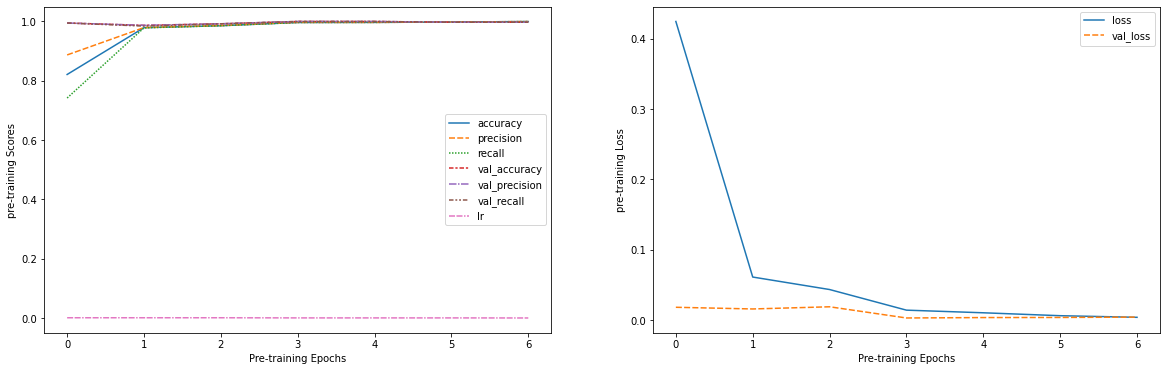

In [4]:
ptmodel, hist, filepath = oset.train_ptmodel(bglog=bglog, train_data=train_data, val_data=val_data, pt_epochs=pt_epochs)

In [8]:
oset.ptmodel_path

'data\\ptmodel_init_2022-04-2416_53_39.309928/'

In [14]:
# ptmodel = oset.import_ptmodel()
ptmodel.layers
ptmodel.summary()
ptmodel.weights

Model: "log_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 log_line_encoder (LogLineEn  multiple                 36918     
 coder)                                                          
                                                                 
 log_seq_encoder (LogSeqEnco  multiple                 37836     
 der)                                                            
                                                                 
 dense_1 (Dense)             multiple                  52        
                                                                 
Total params: 74,806
Trainable params: 74,806
Non-trainable params: 0
_________________________________________________________________


[<tf.Variable 'log_classifier/log_line_encoder/embedding/embeddings:0' shape=(51, 50) dtype=float32, numpy=
 array([[ 9.10613313e-03, -1.43559845e-02,  4.54232953e-02, ...,
          4.11465531e-03, -5.76482480e-03, -2.08856761e-02],
        [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.85527685e-03,  1.00805950e+00,  1.86981019e-02, ...,
         -6.71605673e-03,  4.65195219e-04, -7.55233923e-04],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]], dtype=float32)>,
 <tf.Variable 'log_classifier/log_line_encoder/conv1d/kernel:0' shape=(3, 50, 64) dtype=float32, numpy=
 

In [7]:
import os
mpath = os.path.join('data', 'ptmodel_init_2022-04-2415_18_01.048468', 
                    'model-00001-0.42440-0.82125-0.01815-0.99479.tf')
m = load_model(mpath)
m.summary()

NameError: name 'load_model' is not defined

In [ ]:
MyDev/OCLog/oclog/openset/notebooks/data/ptmodel_init_2022-04-2415_18_01.048468/model-00001-0.42440-0.82125-0.01815-0.99479.tf

In [ ]:
dir(hist)

In [ ]:
hist.on_epoch_end(1)